In [1]:
%load_ext autoreload
%autoreload 2

# Online Outcomes: Predicting Success in Virtual Learning

**<font size="4">Author: Jeffrey Hanif Watson</font>**

## Imports and Project Path

In [108]:
# importing packages
import os, sys, glob, re
import pandas as pd
import numpy as np
import sqlite3

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import functions as fn

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

## Creating SQL Database

**<font size="3">This cell can be run once to establish the database and then commented out.</font>**

In [83]:
# # creating and populating database
# file_name = 'anonymisedData.zip'
# database_name = 'outcomes.db'
# fn.db_create(file_name, database_name)

## Database ERD

![graph0](../../references/schema.png)

## EDA

### SQL Setup
Connecting to database and creating a cursor object.

In [84]:
# creating connection, and cursor
data_path = os.path.join(gparent,'data/processed','outcomes.db')
conn = sqlite3.connect(data_path)  
cur = conn.cursor()

### Checking table names

In [85]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('ASSESSMENTS',),
 ('COURSES',),
 ('STUDENTASSESSMENT',),
 ('STUDENTINFO',),
 ('STUDENTREGISTRATION',),
 ('STUDENTVLE',),
 ('VLE',)]

## Data Understanding

### Codes & Module Summaries

In [86]:
# month codes used in code_presentation
month_codes = {
    'A': 'January', 
    'B': 'Februrary',
    'C': 'March', 
    'D': 'April',
    'E': 'May',
    'F': 'June',
    'G': 'July',
    'H': 'August',
    'I': 'Septemeber',
    'J': 'October',
    'K': 'November',
    'L': 'December'
        }

In [87]:
module_codes = {
    'AAA': {'Domain': 'Social Sciences', 'Presentations': 2, 'Students': 748},
    'BBB': {'Domain': 'Social Sciences', 'Presentations': '4', 'Students': 7909},
    'CCC': {'Domain': 'STEM', 'Presentations': 2, 'Students': 4434},
    'DDD': {'Domain': 'STEM', 'Presentations': 4, 'Students': 6272},
    'EEE': {'Domain': 'STEM', 'Presentations': 3, 'Students': 2934},
    'FFF': {'Domain': 'STEM', 'Presentations': 4, 'Students': 7762},
    'GGG': {'Domain': 'Social Sciences', 'Presentations': 3, 'Students': 2534}
}

In [88]:
# checking work
print('Students')
print('---------')
for key in module_codes.keys():
    print(key, module_codes[key]['Students'])

Students
---------
AAA 748
BBB 7909
CCC 4434
DDD 6272
EEE 2934
FFF 7762
GGG 2534


### Creating Data Frames

### Student Info

In [89]:
# creating student_info dataframe and appending column names
q = "SELECT*FROM STUDENTINFO"
student_info = pd.DataFrame(fn.fetch(cur, q))
student_info.columns = [i[0] for i in cur.description]

In [90]:
# checking first five rows
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [91]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB


In [92]:
student_info.shape

(32593, 12)

In [93]:
student_info.imd_band.value_counts(normalize=True)

20-30%     0.116066
30-40%     0.112413
10-20      0.111683
0-10%      0.105171
40-50%     0.103424
50-60%     0.099231
60-70%     0.092275
70-80%     0.091449
80-90%     0.087733
90-100%    0.080554
Name: imd_band, dtype: float64

In [94]:
student_info.age_band.value_counts(normalize=True)

0-35     0.703955
35-55    0.289418
55<=     0.006627
Name: age_band, dtype: float64

In [95]:
student_info.highest_education.value_counts(normalize=True)

A Level or Equivalent          0.430921
Lower Than A Level             0.403706
HE Qualification               0.145123
No Formal quals                0.010646
Post Graduate Qualification    0.009603
Name: highest_education, dtype: float64

In [114]:
student_info.final_result.value_counts(normalize=True)

Pass           0.379253
Withdrawn      0.311601
Fail           0.216365
Distinction    0.092781
Name: final_result, dtype: float64

In [96]:
student_info.duplicated('id_student', keep=False).sum()

7346

In [97]:
dupe_ids = student_info[student_info['id_student'].duplicated(keep=False)]\
.sort_values(by=['id_student']).reset_index()

In [98]:
dupe_ids.final_result.value_counts()

Withdrawn      3302
Pass           2160
Fail           1307
Distinction     577
Name: final_result, dtype: int64

In [99]:
dupe_ids

,index,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,10637,CCC,2014J,100788,M,Scotland,HE Qualification,80-90%,0-35,1,60,N,Distinction
1,23954,FFF,2013J,100788,M,Scotland,HE Qualification,80-90%,0-35,0,90,N,Pass
2,27730,FFF,2014J,101217,M,London Region,A Level or Equivalent,40-50%,35-55,2,60,Y,Fail
3,23955,FFF,2013J,101217,M,London Region,A Level or Equivalent,40-50%,35-55,1,90,Y,Withdrawn
4,12835,CCC,2014J,1031884,M,East Midlands Region,A Level or Equivalent,80-90%,35-55,0,60,N,Distinction
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7341,8694,CCC,2014B,97486,M,North Western Region,HE Qualification,70-80%,35-55,0,60,N,Withdrawn
7342,25961,FFF,2013J,988019,F,London Region,A Level or Equivalent,20-30%,35-55,1,60,Y,Fail
7343,23707,FFF,2013B,988019,F,London Region,A Level or Equivalent,20-30%,35-55,0,60,Y,Withdrawn
7344,17406,DDD,2014B,997948,M,North Western Region,A Level or Equivalent,20-30%,55<=,1,120,N,Withdrawn


In [20]:
# student_info.drop_duplicates(subset='id_student', keep='first', inplace=True)

In [21]:
student_info.final_result.unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

### Student VLE

In [22]:
# creating student_vle dataframe and appending column names
q = "SELECT*FROM STUDENTVLE"
student_vle = pd.DataFrame(fn.fetch(cur, q))
student_vle.columns = [i[0] for i in cur.description]

In [23]:
student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [24]:
student_vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         object
 3   id_site            object
 4   date               object
 5   sum_click          object
dtypes: object(6)
memory usage: 487.8+ MB


In [25]:
student_vle[['date','sum_click']] = student_vle[['date','sum_click']].apply(pd.to_numeric)

In [26]:
student_vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         object
 3   id_site            object
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(2), object(4)
memory usage: 487.8+ MB


In [27]:
student_sorted = student_vle.groupby('id_student')

In [28]:
clicks = student_sorted['sum_click'].sum()

In [29]:
clicks.sort_values(ascending=False)

id_student
80868     28615
630905    28264
537811    25159
619927    24368
434476    21204
          ...  
676194        1
102849        1
75309         1
639232        1
576481        1
Name: sum_click, Length: 26074, dtype: int64

#### Student 28400

In [30]:
id_28400 = student_vle[student_vle['id_student']=='28400']

In [31]:
id_28400.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 174007
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   code_module        430 non-null    object
 1   code_presentation  430 non-null    object
 2   id_student         430 non-null    object
 3   id_site            430 non-null    object
 4   date               430 non-null    int64 
 5   sum_click          430 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [32]:
len(id_28400.id_site.unique())

84

In [33]:
id_28400.code_module.unique()

array(['AAA'], dtype=object)

In [34]:
id_28400.sum_click.sum()

1435

In [35]:
date_sorted = id_28400.sort_values(by=['date']).reset_index(drop=True)

In [113]:
date_sorted.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546871,-10,3
2,AAA,2013J,28400,547013,-10,1
3,AAA,2013J,28400,547011,-10,1
4,AAA,2013J,28400,546890,-10,1


In [101]:
date_clix = pd.DataFrame(id_28400.groupby('date')['sum_click'].sum()).reset_index()

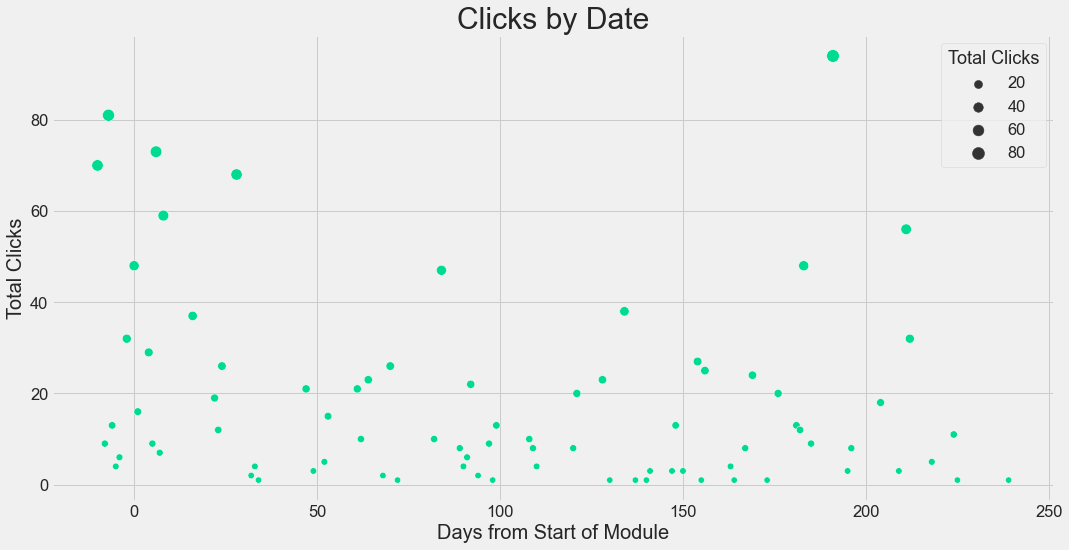

In [109]:
fig, ax=plt.subplots(figsize=(16,8))
sns.scatterplot(x='date', y='sum_click', size='sum_click', data=date_clix)
plt.title('Clicks by Date', fontsize=30)
plt.legend(title='Total Clicks')
plt.ylabel('Total Clicks', fontsize=20)
plt.xlabel('Days from Start of Module', fontsize=20)
plt.show()